In [ ]:
try:
    import pyro
except:
    ! pip install pyro-ppl
    ! pip install Biopython

     |████████████████████████████████| 718 kB 8.1 MB/s 
     |████████████████████████████████| 2.3 MB 5.6 MB/s 


## Prepare

In [ ]:
import numpy as np
from tqdm import tqdm
from Bio import Phylo

In [ ]:
leaf_seq_path = "/content/realign_MSA.fas"
tree_path = "/content/_True_Rooted_tree_node_labels.tre"

## IID Model

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_all, S_names_all, S_char_all = load_MSA_Data(leaf_seq_path, "cuda", AA_dict)

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names_all), :len(S_names_all)]

In [ ]:
np.random.seed(42)
inds = np.random.choice(S_all.shape[0], S_all.shape[0], False)
train_idx = inds[:int(S_all.shape[0] * 0.7)]
test_idx = inds[int(S_all.shape[0] * 0.7):]

S_train, S_names_train, S_char_train = S_all[train_idx], np.array(S_names_all)[train_idx].tolist(), np.array(S_char_all)[train_idx].tolist()
S_test, S_names_test, S_char_test = S_all[test_idx], np.array(S_names_all)[test_idx].tolist(), np.array(S_char_all)[test_idx].tolist(),

In [ ]:
pyro.clear_param_store()
vae = VAE(100, 24, S_train.shape[1])
def per_param_callable(module_name, param_name):
    # if param_name in ["msa_ref_loc"]:
    #     return {"lr": 1, "clip_norm": 10}
    # else:   
    return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.iid_model, vae.iid_guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []
Rec_Acc = []
Rec_Acc_remove_gap = []

train_corr = []
test_corr = []

In [ ]:
batch_size = 128

In [ ]:
true_tree_distances_train = true_tree_distances[:, [S_names_all.index(i) for i in S_names_train]][[S_names_all.index(i) for i in S_names_train], :]
true_tree_distances_test = true_tree_distances[:, [S_names_all.index(i) for i in S_names_test]][[S_names_all.index(i) for i in S_names_test], :]

In [ ]:
for b in tqdm(range(201)):
    elbos = []
    for batch in range(int(np.ceil(S_train.shape[0] / batch_size))):
        s = S_train[batch_size * batch: batch_size * (batch + 1)]
        elbo = svi.step(s, S_train.shape[0] / s.shape[0])
        elbos.append(elbo)
    ELBOs.append(np.array(elbo).mean())

    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()

            Z_loc = vae.encoder(MSA, None).detach()
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=False)))


            # Distances Correlation

            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            #latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
            latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            train_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])



            S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            #latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
            latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            test_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])

           

100%|██████████| 201/201 [06:19<00:00,  1.89s/it]


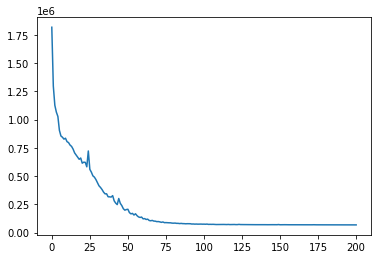

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

0.9986380437838128


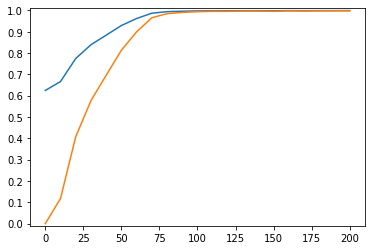

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.plot(np.arange(len(Rec_Acc_remove_gap)) * 10, Rec_Acc_remove_gap)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))
print(max(Rec_Acc_remove_gap[1:]))

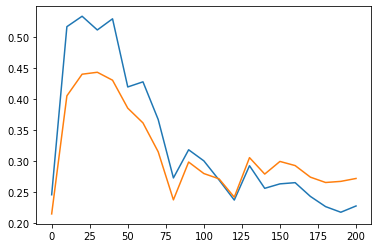

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(train_corr)) * 10, train_corr)
plt.plot(np.arange(len(test_corr)) * 10, test_corr)
plt.show()

spearmanr:  0.22762839249833997
pearson:  0.4434573304066388


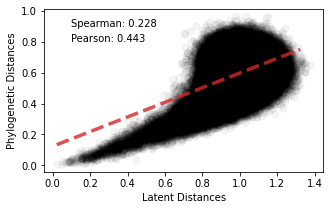

In [ ]:

# Distances Correlation

S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
#latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]

print("spearmanr: ", spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
print("pearson: ", pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])

parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.1, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.1, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")
# plt.xlim(0, 5.5)
# plt.ylim(-0.5, 4.0)
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=0.8, linestyle="--")

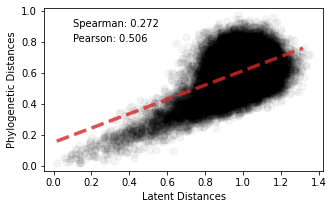

In [ ]:
S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
#latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]



parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.1, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.1, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")

# plt.xticks([0, 1, 2, 3, 4])
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=.8, linestyle="--")

## Draupnir

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_all, S_names_all, S_char_all = load_MSA_Data(leaf_seq_path, "cuda", AA_dict)

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names_all), :len(S_names_all)]

In [ ]:
np.random.seed(42)
inds = np.random.choice(S_all.shape[0], S_all.shape[0], False)
train_idx = inds[:int(S_all.shape[0] * 0.7)]
test_idx = inds[int(S_all.shape[0] * 0.7):]

S_train, S_names_train, S_char_train = S_all[train_idx], np.array(S_names_all)[train_idx].tolist(), np.array(S_char_all)[train_idx].tolist()
S_test, S_names_test, S_char_test = S_all[test_idx], np.array(S_names_all)[test_idx].tolist(), np.array(S_char_all)[test_idx].tolist(),

In [ ]:
pyro.clear_param_store()
vae = VAE(100, 24, S_train.shape[1])
def per_param_callable(module_name, param_name):
    if param_name in ["tree_embed_loc", "tree_embed_len"]:
        return {"lr": 0.01, "clip_norm": 10}
    elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
        return {"lr": 1e-6, "clip_norm": 10}
    else:   
        return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []
Rec_Acc = []
Rec_Acc_remove_gap = []

train_corr = []
test_corr = []

In [ ]:
batch_size = 128

In [ ]:
true_tree_distances_train = true_tree_distances[:, [S_names_all.index(i) for i in S_names_train]][[S_names_all.index(i) for i in S_names_train], :]
true_tree_distances_test = true_tree_distances[:, [S_names_all.index(i) for i in S_names_test]][[S_names_all.index(i) for i in S_names_test], :]

In [ ]:
for b in tqdm(range(201)):
    indices = np.random.choice(S_train.shape[0], S_train.shape[0], False)
    elbos = []
    for batch in range(S_train.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S_train.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])
      elbo = svi.step(aligned_S=S_train[batch_idx],
               S_length=None,
               S_index=batch_idx,
               num_batch=S_train.shape[0] // batch_size - 1,
               aligned_S_back=S_train[back_idx],
               S_back_length=None,
               S_back_index=back_idx,
               num_instance=S_train.shape[0],
               tree_emb_dim=100)
      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))


    
    if b == 120:
        def per_param_callable(module_name, param_name):
          if param_name in ["tree_embed_loc", "tree_embed_len"]:
              return {"lr": 1e-7, "clip_norm": 10}
          elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
              return {"lr": 1e-5, "clip_norm": 10}
          else:   
              return {"lr": 0.0005, "clip_norm": 10}
        optimizer = pyro.optim.ClippedAdam(per_param_callable)
        svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))



    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()

            Z_loc = vae.encoder(MSA, None).detach()
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=False)))


            # Distances Correlation

            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            #latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
            latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            train_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])



            S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            #latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
            latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            test_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])

           

100%|██████████| 201/201 [25:59<00:00,  7.76s/it]


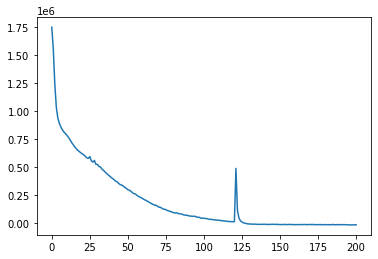

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

0.9991152434935224


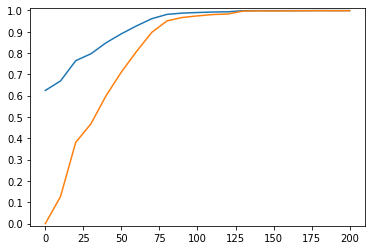

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.plot(np.arange(len(Rec_Acc_remove_gap)) * 10, Rec_Acc_remove_gap)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))
print(max(Rec_Acc_remove_gap[1:]))

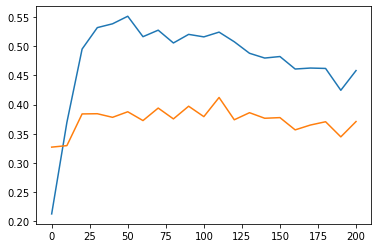

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(train_corr)) * 10, train_corr)
plt.plot(np.arange(len(test_corr)) * 10, test_corr)
plt.show()

spearmanr:  0.4581853944484197
pearson:  0.6432677998098306


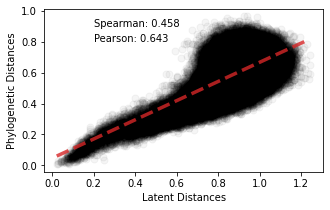

In [ ]:

# Distances Correlation

S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
#latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]

print("spearmanr: ", spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
print("pearson: ", pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])

parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.2, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.2, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")
# plt.xlim(0, 5.5)
# plt.ylim(-0.5, 4.0)
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=0.8, linestyle="--")

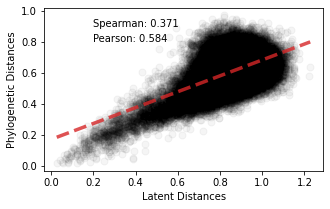

In [ ]:
S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
#latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]



parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.2, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.2, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")

# plt.xticks([0, 1, 2, 3, 4])
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=.8, linestyle="--")

In [ ]:
# pyro.param("sigma_f_loc"), pyro.param("sigma_n_loc"), pyro.param("lambd_loc")

In [ ]:
# tree_emb_loc, tree_emb_len = pyro.param("tree_embed_loc"), pyro.param("tree_embed_len")
# tree_embedding = tree_emb_loc / tree_emb_loc.norm(dim=-1, keepdim=True) * tree_emb_len
# batch_distance = vae._get_D(tree_embedding, 0).detach().cpu()

In [ ]:
# embed_distances_upper = batch_distance.cpu().numpy()[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
# real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]

# Spearmans_dis = spearmanr(embed_distances_upper, real_distance_upper)[0]
# Pearsons_dis = pearsonr(embed_distances_upper, real_distance_upper)[0]

In [ ]:
# Spearmans_dis, Pearsons_dis 